### ML - Regression (Price-Rating)

In [2]:
#Database management
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_columns', None)

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

##ML
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
#Import data
best = pd.read_csv('Data/best_clean2.csv')

In [4]:
best.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52478 entries, 0 to 52477
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookid            52478 non-null  object 
 1   title             52478 non-null  object 
 2   series            52478 non-null  object 
 3   author            52478 non-null  object 
 4   rating            52478 non-null  float64
 5   description       52478 non-null  object 
 6   language          52478 non-null  object 
 7   isbn              52478 non-null  object 
 8   characters        52478 non-null  object 
 9   bookformat        52478 non-null  object 
 10  edition           52478 non-null  object 
 11  pages             52478 non-null  int64  
 12  publisher         52478 non-null  object 
 13  publishdate       50693 non-null  object 
 14  firstpublishdate  31135 non-null  object 
 15  awards            52478 non-null  object 
 16  numratings        52478 non-null  int64 

### Pre-processing (outliers-nulls)

In [5]:
#erase firstpublishdate column
best.drop('firstpublishdate', axis=1, inplace=True)

In [6]:
# Checking for null values but I will have to look into it as some values are not null but 0
nulls = pd.DataFrame(best.isna().sum()/len(best))
nulls= nulls.reset_index()
nulls.columns = ['column_name', 'Percentage Null Values']
nulls.sort_values(by='Percentage Null Values', ascending = False)

,column_name,Percentage Null Values
13,publishdate,0.034014
0,bookid,0.000000
15,numratings,0.000000
26,1_star,0.000000
25,2_star,0.000000
24,3_star,0.000000
23,4_star,0.000000
22,5_star,0.000000
21,price,0.000000
20,bbevotes,0.000000


#### Price

In [7]:
#Dealing with outliers PRICE
# Checking how many values will be removed if the outliers are removed
iqr = np.percentile(best['price'],75) - np.percentile(best['price'],25)
upper_limit = np.percentile(best['price'],75) + 1.5*iqr
print(upper_limit)

1630.0


In [8]:
removed = best[best['price'] > upper_limit]
len(removed)  # This checks the number of outliers that will be removed

3971

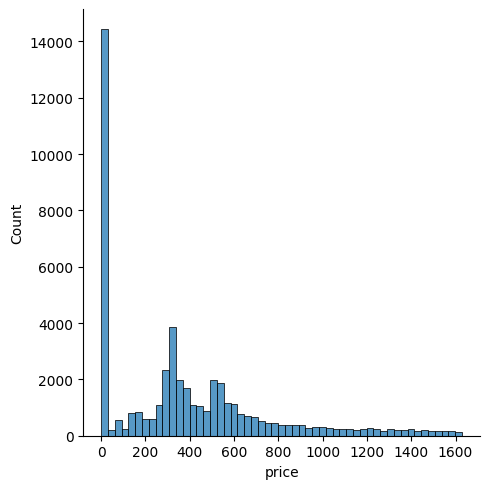

In [9]:
# Removing outliers
best = best[best['price'] < upper_limit]
sns.displot(best['price'])
plt.show()

In [10]:
best['price'].describe()

count    48501.000000
mean       388.579349
std        383.233492
min          0.000000
25%          0.000000
50%        325.000000
75%        561.000000
max       1629.000000
Name: price, dtype: float64

In [11]:
#Dealing with 0 values
#Checking how many values will be removed if the 0 values are removed
missing_price_count = best[best['price'] == 0].shape[0]
print(f"Registros con 'price' igual a cero (missing data): {missing_price_count}")

Registros con 'price' igual a cero (missing data): 14365


In [12]:
best.shape

(48501, 28)

In [13]:
#Instead of imputing the  14365  values that have 0 (using median or mean), I will remove them because 
#otherwise they create a bias in the model
best = best[best['price'] != 0]
best.shape

(34136, 28)

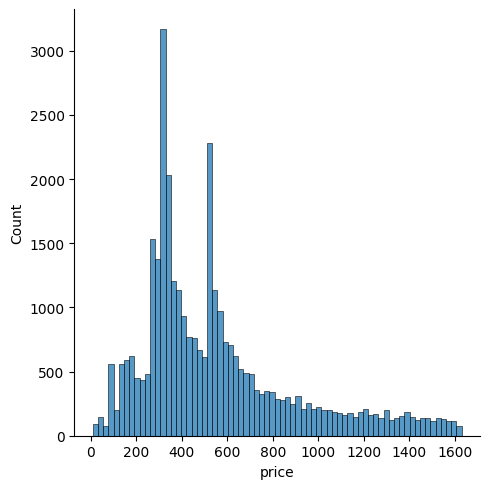

In [14]:
sns.displot(best['price'])
plt.show()

In [15]:
#I try to do a  log or sqrt transformation, because the values are a bit right skewed

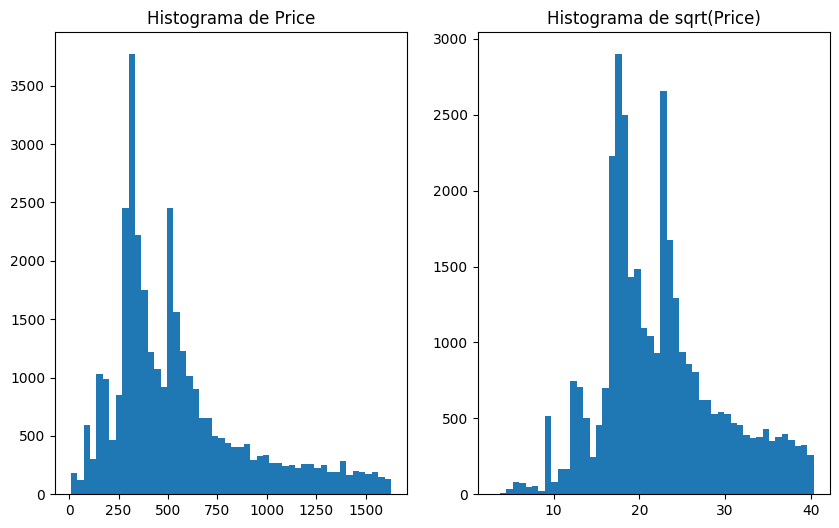

In [16]:
#apply sqrt transformation
best['price_sqrt'] = np.sqrt(best['price'])

#check distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(best['price'], bins=50)
plt.title('Histograma de Price')

plt.subplot(1, 2, 2)
plt.hist(best['price_sqrt'], bins=50)
plt.title('Histograma de sqrt(Price)')
plt.show()


#### Pages

Text(0.5, 1.0, 'Histograma de Pages')

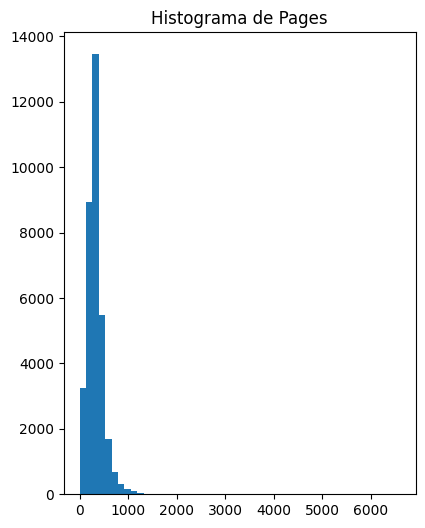

In [17]:
#Check best['pages'] distribution 
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(best['pages'], bins=50)
plt.title('Histograma de Pages')

In [18]:
best['pages'].describe()

count    34136.000000
mean       324.622481
std        179.805781
min          0.000000
25%        224.000000
50%        310.000000
75%        394.000000
max       6600.000000
Name: pages, dtype: float64

In [19]:
#Find the index of the book with the maximum value in 'pages'
max_pages_index = best['pages'].idxmax()
book_with_max_pages = best.loc[max_pages_index]


print("Información del libro con el máximo valor de 'pages':")
print(book_with_max_pages)


Información del libro con el máximo valor de 'pages':
bookid                                                   30807879
title                                         سه تفنگدار: ١٠ جلدی
series                                 Les Trois Mousquetaires #1
author                          Alexandre Dumas, ذبیح‌الله منصوری
rating                                                       4.23
description     Cei trei muschetari (Les Trois Mousquetaires) ...
language                                                  Persian
isbn                                                9782070365265
characters                                                     []
bookformat                                              Hardcover
edition                                                   Unknown
pages                                                        6600
publisher                                           نگارستان کتاب
publishdate                                                   NaN
awards                

After checking online for this particular outlier, it seems that the pages listed are not the pages from this specific book but for all the series of books.. 
It is helpful to understand why these books have an unusually high number of pages. There may be several legitimate reasons for this, such as encyclopedias, complete collections (as this case), or errors in data collection. So I think it's not the best option to remove them.

In [20]:
#Checking how many values will be removed if the outliers are removed
iqr = np.percentile(best['pages'],75) - np.percentile(best['pages'],25)
upper_limit = np.percentile(best['pages'],75) + 1.5*iqr
print(upper_limit)

649.0


In [21]:
removed = best[best['price'] > upper_limit]
len(removed)  # This checks the number of outliers that will be removed

9221

In [22]:
#checking how many values will be removed if the 0 values are removed
missing_pages_count = best[best['pages'] == 0].shape[0]
print(f"Registros con 'pages' igual a cero (missing data): {missing_pages_count}")

Registros con 'pages' igual a cero (missing data): 579


In [23]:
#I will impute the 0 values with the median
best['pages'] = best['pages'].replace(0, best['pages'].median())

In [24]:
#In this cas I will apply a transformation
best['pages_log'] = np.log1p(best['pages'])  #np.log1p to avoid negative values 

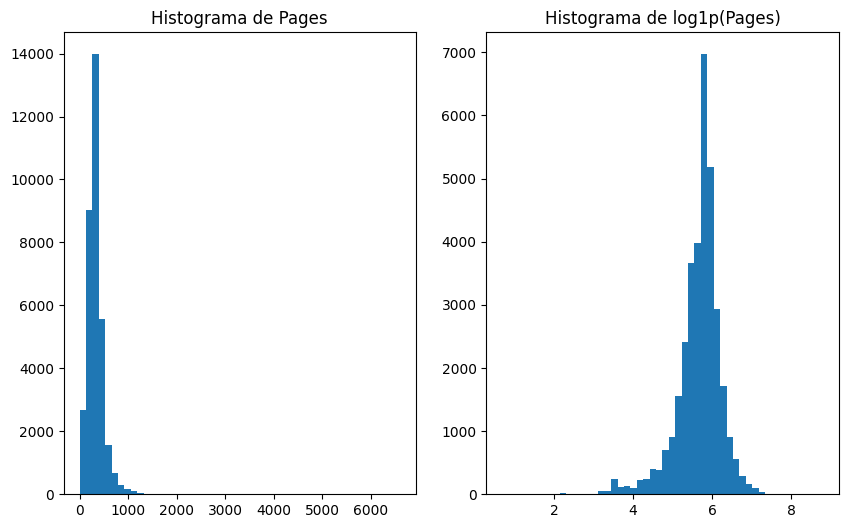

In [25]:
#check distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(best['pages'], bins=50)
plt.title('Histograma de Pages')

plt.subplot(1, 2, 2)
plt.hist(best['pages_log'], bins=50)
plt.title('Histograma de log1p(Pages)')
plt.show()

#### NumRatings

Text(0.5, 1.0, 'Histograma de numratings')

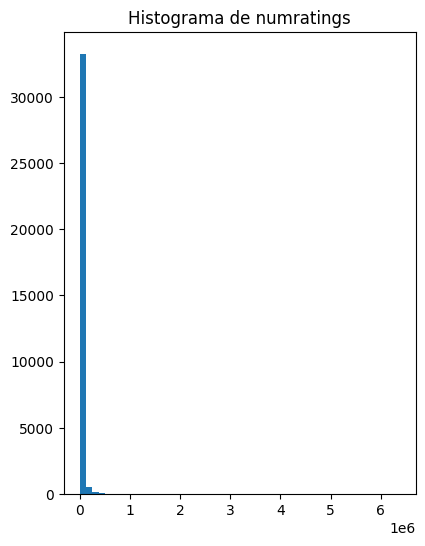

In [26]:
# check best['numratings'] distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(best['numratings'], bins=50)
plt.title('Histograma de numratings')

In [27]:
best['numratings'].describe()

count    3.413600e+04
mean     2.070661e+04
std      9.903496e+04
min      0.000000e+00
25%      8.300000e+02
50%      3.694500e+03
75%      1.280625e+04
max      6.376780e+06
Name: numratings, dtype: float64

In [28]:
#Count the number of observations with 'numratings' equal to zero
zero_ratings_count = best[best['numratings'] == 0].shape[0]
print(f"observations with 'numratings' equal to zero (missing data): {zero_ratings_count}")

observations with 'numratings' equal to zero (missing data): 13


In [29]:
#I will impute the 0 values with the median
best['numratings'] = best['numratings'].replace(0, best['numratings'].median())

In [30]:
#Checking how many values will be removed if the outliers are removed
iqr = np.percentile(best['numratings'],75) - np.percentile(best['numratings'],25)
upper_limit = np.percentile(best['numratings'],75) + 1.5*iqr
print(upper_limit)

30765.0


In [31]:
removed = best[best['numratings'] > upper_limit]
len(removed)  # This checks the number of outliers that will be removed

4204

In [32]:
#I will transform the data
best['numratings_log'] = np.log1p(best['numratings'])

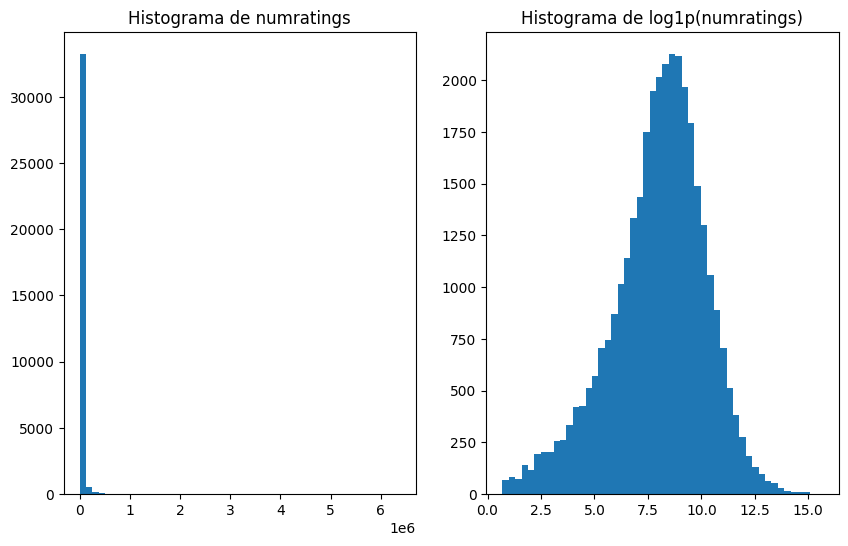

In [33]:
#check distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(best['numratings'], bins=50)
plt.title('Histograma de numratings')

plt.subplot(1, 2, 2)
plt.hist(best['numratings_log'], bins=50)
plt.title('Histograma de log1p(numratings)')
plt.show()

#### Rating

Text(0.5, 1.0, 'Histograma de rating')

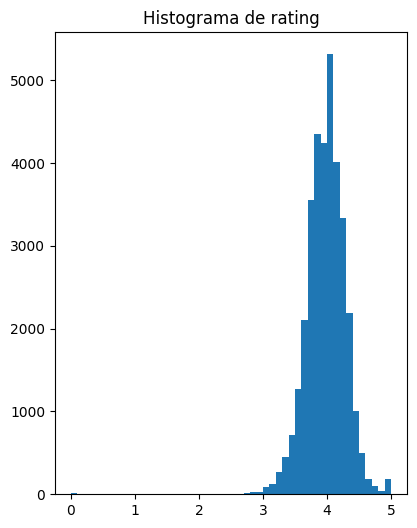

In [34]:
#check rating distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(best['rating'], bins=50)
plt.title('Histograma de rating')

In [35]:
#Count the number of observations with 'rating' equal to zero
zero_ratings_count = best[best['rating'] == 0].shape[0]
print(f"observations with 'rating' equal to zero (missing data): {zero_ratings_count}")

observations with 'rating' equal to zero (missing data): 13


In [36]:
best['rating'].describe()

count    34136.000000
mean         3.979169
std          0.303869
min          0.000000
25%          3.800000
50%          3.990000
75%          4.170000
max          5.000000
Name: rating, dtype: float64

In [37]:
#It can be possible that a rating is 0 as someone may have given a book a rating of 0

In [38]:
#Transform the data sqrt
best['rating_sqrt'] = np.sqrt(best['rating'])
best['rating_sqrt'].describe()

count    34136.000000
mean         1.993020
std          0.083899
min          0.000000
25%          1.949359
50%          1.997498
75%          2.042058
max          2.236068
Name: rating_sqrt, dtype: float64

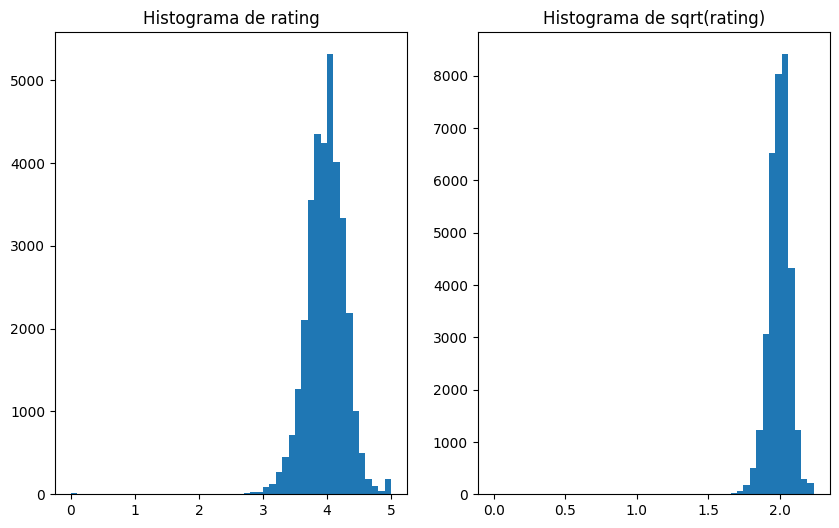

In [39]:
#check distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(best['rating'], bins=50)
plt.title('Histograma de rating')

plt.subplot(1, 2, 2)
plt.hist(best['rating_sqrt'], bins=50)
plt.title('Histograma de sqrt(rating)')
plt.show()

In [40]:
#remove rating_sqrt
best = best.drop('rating_sqrt', axis=1)

In [41]:
#It makes no sense as the ratings are from 0 to 5 I will leave them as they are

#### Likedpercent

Text(0.5, 1.0, 'Histograma de likedpercent')

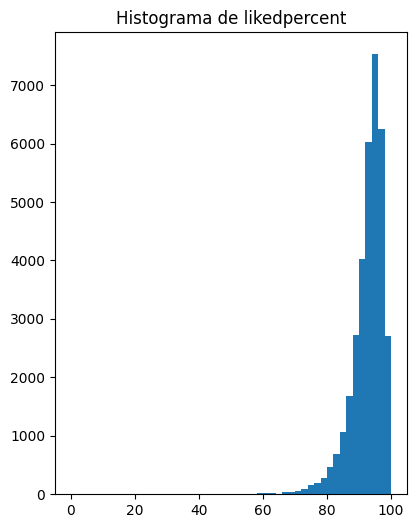

In [42]:
#check distribution      
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(best['likedpercent'], bins=50)
plt.title('Histograma de likedpercent')



In [43]:
#This distribution makes sense as it is a percentage

In [44]:
best.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34136 entries, 0 to 52477
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bookid          34136 non-null  object 
 1   title           34136 non-null  object 
 2   series          34136 non-null  object 
 3   author          34136 non-null  object 
 4   rating          34136 non-null  float64
 5   description     34136 non-null  object 
 6   language        34136 non-null  object 
 7   isbn            34136 non-null  object 
 8   characters      34136 non-null  object 
 9   bookformat      34136 non-null  object 
 10  edition         34136 non-null  object 
 11  pages           34136 non-null  int64  
 12  publisher       34136 non-null  object 
 13  publishdate     33715 non-null  object 
 14  awards          34136 non-null  object 
 15  numratings      34136 non-null  float64
 16  likedpercent    34136 non-null  float64
 17  setting         34136 non-null  obje

### Testing models

### Target = price

In [45]:
#Drop what may be considered irrelevant columns
drop_columns = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate']

In [46]:
X = best.drop(['price'] + drop_columns, axis=1)  
y = best['price']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
#encode categorical features
categorical_features = [
    'series', 'author', 'language', 'bookformat', 'publisher', 'genre', 
    'edition', 'characters', 'awards', 'setting'
]

numerical_features = [col for col in X.columns if col not in categorical_features]


In [49]:
#define pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(with_mean=False), numerical_features)
    ]
)

In [50]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

#Fit and transform the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)


In [51]:
#X_train_processed_df = pd.DataFrame(X_train_processed.toarray() if hasattr(X_train_processed, "toarray") else X_train_processed)

In [52]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNeighbors Regressor': KNeighborsRegressor()
}

In [53]:
for name, model in models.items():
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    print(f'{name} performance:')
    print('MSE:', mean_squared_error(y_test, y_pred))
    print('MAE:', mean_absolute_error(y_test, y_pred))
    print('R^2:', r2_score(y_test, y_pred))

Linear Regression performance:
MSE: 10061.134294685717
MAE: 64.99791182027232
R^2: 0.9141592461772566
Decision Tree performance:
MSE: 0.015084944346807265
MAE: 0.013620386643233744
R^2: 0.9999998712965202
KNeighbors Regressor performance:
MSE: 10179.994938488577
MAE: 72.10726420620972
R^2: 0.9131451371349707


As this is a first attempt, it seems overfitted, let's tune parameters

In [54]:
from scipy.stats import chi2_contingency

for cat_feature in categorical_features:
    crosstab = pd.crosstab(best[cat_feature], best['price'])
    chi2, p, dof, ex = chi2_contingency(crosstab)
    print(f'Chi2 for {cat_feature}: {chi2}, p-value: {p}')

Chi2 for series: 22295435.68569248, p-value: 1.0
Chi2 for author: 33403441.9163531, p-value: 0.0
Chi2 for language: 112622.31969231609, p-value: 0.0
Chi2 for bookformat: 166871.18200200217, p-value: 0.0
Chi2 for publisher: 11961044.32987606, p-value: 0.0
Chi2 for genre: 46792.13865947734, p-value: 8.901582745342726e-177
Chi2 for edition: 2041936.579665433, p-value: 0.0
Chi2 for characters: 14252787.205635715, p-value: 1.0
Chi2 for awards: 11610083.215854075, p-value: 1.0
Chi2 for setting: 5828645.409844121, p-value: 1.0


chi-square tests of independence between each categorical feature (cat_feature) and the price variable

p-value:
This value indicates the probability of observing a chi-square statistic as extreme as the one computed, under the null hypothesis that there is no association between the categorical feature and price.
A low p-value (typically < 0.05) suggests that there is significant evidence to reject the null hypothesis, indicating that the categorical feature and price are likely associated.
A high p-value (close to 1.0) suggests that there is no significant evidence to reject the null hypothesis, indicating that the categorical feature and price are likely independent.
Based on your results:

- For series, characters, awards, and setting, the p-values are all very high (close to 1.0). This suggests that there is no significant evidence to reject the null hypothesis that these categorical features are independent of price.

- For author, language, bookformat, publisher, genre, and edition, the p-values are very low (close to 0.0 or extremely small). This indicates strong evidence to reject the null hypothesis, suggesting that these categorical features are significantly associated with price.

In [55]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'decisiontree': {'max_depth': [3, 5, 7]},
    'knn': {'n_neighbors': [3, 5, 7]}
}

grid_search = GridSearchCV(DecisionTreeRegressor(), param_grid['decisiontree'], cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_processed, y_train)
print('Best parameters for Decision Tree:', grid_search.best_params_)


grid_search = GridSearchCV(KNeighborsRegressor(), param_grid['knn'], cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_processed, y_train)
print('Best parameters for KNN:', grid_search.best_params_)

Best parameters for Decision Tree: {'max_depth': 7}
Best parameters for KNN: {'n_neighbors': 7}


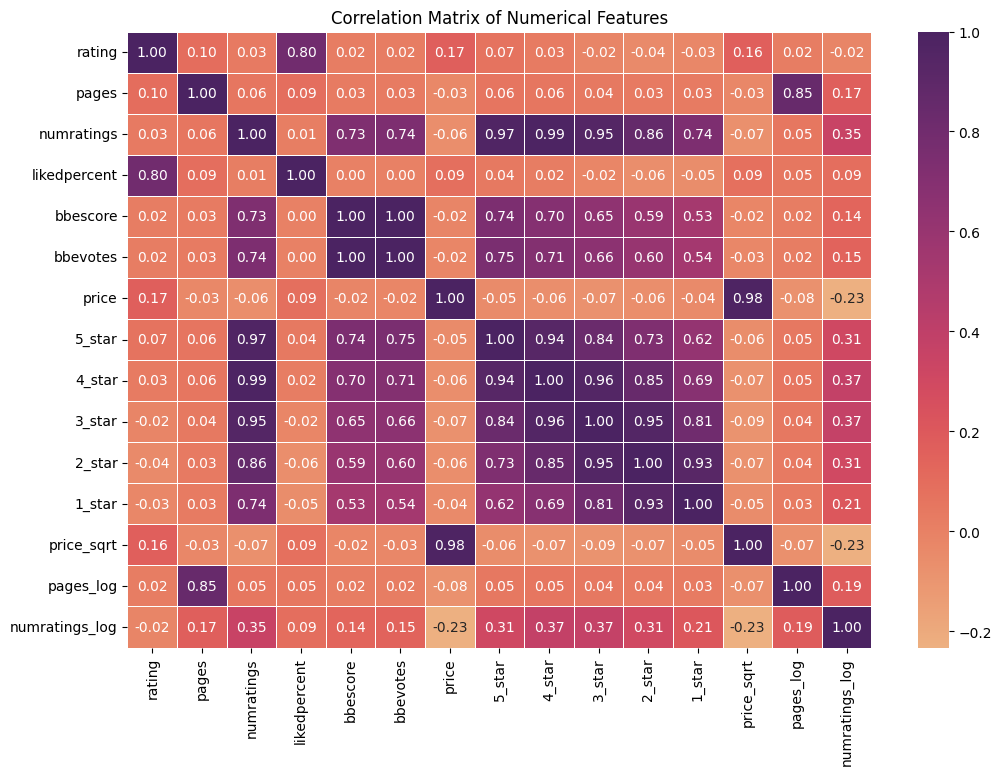

In [56]:
#visualize matrix of numerical features
numerical = best.select_dtypes(include=np.number)
correlation_matrix = numerical.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='flare', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [57]:
#All the x_star variables are highly correlated with bbescore/bbevotes

After this firts test/attempt:
- CATEGORICAL:
    I will consider dropping categorical columns with p-value close to 1.0
    ``series``, ``characters``, ``awards``, and ``setting``
    Before that I'll try:
    Encode `series` if its part of a serie True if not, false
    Encode `awards` the book have won any award, or not.
- NUMERICAL:
    I will try to drop 1-4 stars first and then check on bbscore, etc.



In [58]:
#cleaning the column series: 1 or 0 
def clean_series_to_binary(series_value):
    if series_value == 'Not part of a series':
        return 0
    else:
        return 1

In [59]:
best['series'] = best['series'].apply(clean_series_to_binary)

In [60]:
#cleaning the column awards: 1 or 0
def clean_awards_to_binary(awards_value):
    if awards_value == '[]' or awards_value == []:
        return 0
    else:
        return 1

In [61]:
best['awards'] = best['awards'].apply(clean_awards_to_binary)

In [62]:
best['genre'].value_counts()

genre
Non-Fiction and Others       10394
Classics                      6775
Literature by Region          5946
Horror                        4568
Fantasy                       1921
Erotica                       1384
Fiction                        907
Religion and Spirituality      729
Economy                        715
Nature and Animals             158
Comic and Manga                152
History                        105
World                           87
Science                         69
Romance                         55
Arts and Creativity             46
Psychology                      46
Culture and Society             24
Health                          23
Mystery                         12
Sports                          10
Computer Science                 4
Crime                            2
Languages                        2
Science Fiction                  2
Name: count, dtype: int64

In [63]:
crosstab = pd.crosstab(best['genre'], best['series'], margins=True)
crosstab

series,0,1,All
genre,,,
Arts and Creativity,44,2,46
Classics,4171,2604,6775
Comic and Manga,32,120,152
Computer Science,3,1,4
Crime,2,0,2
Culture and Society,18,6,24
Economy,655,60,715
Erotica,486,898,1384
Fantasy,323,1598,1921


In [64]:
crosstab = pd.crosstab(best['genre'], best['awards'], margins=True)
crosstab

awards,0,1,All
genre,,,
Arts and Creativity,45,1,46
Classics,4530,2245,6775
Comic and Manga,127,25,152
Computer Science,4,0,4
Crime,2,0,2
Culture and Society,24,0,24
Economy,570,145,715
Erotica,1027,357,1384
Fantasy,1513,408,1921


### New attempts

In [65]:
#drop redundant columns and not needed columns:
to_drop = ['publisher', 'characters', 'setting','bookid', 
           'title', 'description', 'isbn', 'coverimg','publishdate', '4_star','3_star','2_star','1_star']

In [66]:
#define X and y
X = best.drop(['price'] + to_drop, axis=1)
y = best['price']

In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34136 entries, 0 to 52477
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   series          34136 non-null  int64  
 1   author          34136 non-null  object 
 2   rating          34136 non-null  float64
 3   language        34136 non-null  object 
 4   bookformat      34136 non-null  object 
 5   edition         34136 non-null  object 
 6   pages           34136 non-null  int64  
 7   awards          34136 non-null  int64  
 8   numratings      34136 non-null  float64
 9   likedpercent    34136 non-null  float64
 10  bbescore        34136 non-null  int64  
 11  bbevotes        34136 non-null  int64  
 12  5_star          34136 non-null  int64  
 13  genre           34136 non-null  object 
 14  price_sqrt      34136 non-null  float64
 15  pages_log       34136 non-null  float64
 16  numratings_log  34136 non-null  float64
dtypes: float64(6), int64(6), object(5)
m

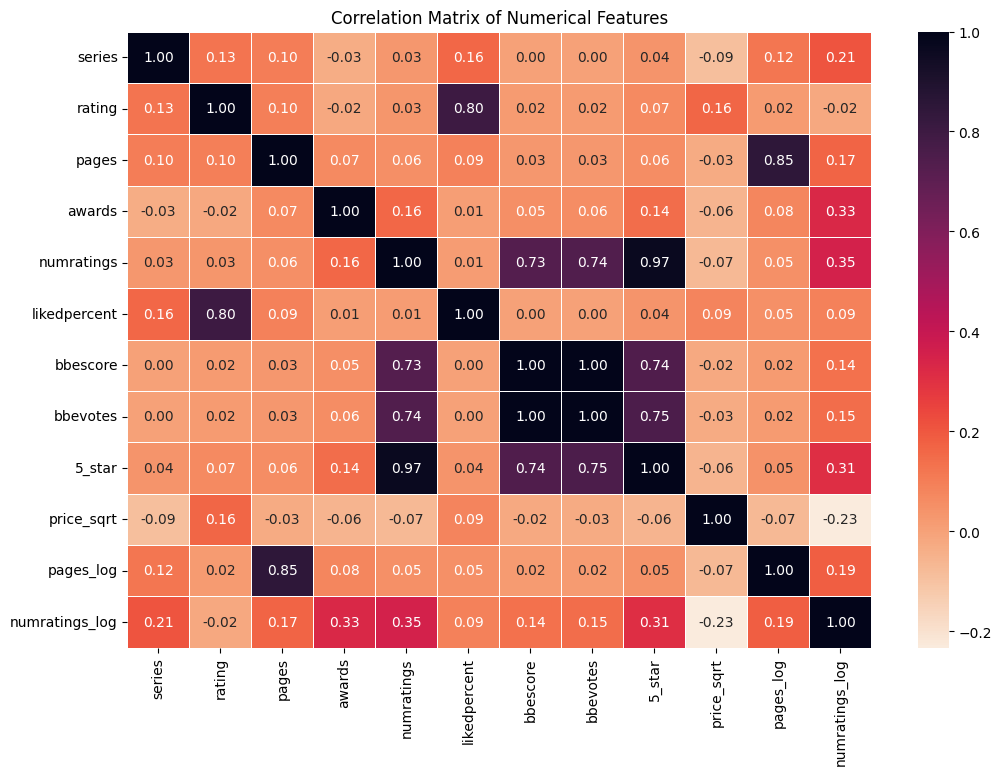

In [69]:
# numerical (X) heatmap
numerical = X.select_dtypes(include=np.number)
correlation_matrix = numerical.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket_r', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [70]:
#Based on the heatmap, I will drop the following columns
X = X.drop(["numratings"], axis=1)

In [71]:
#Dropping categorical columns not needed
X = X.drop(["language","bookformat"], axis=1)

In [72]:
#Let's check VIF
#If I try without dropping all the following columns at minimum I het error of infinite mulicollinearity

In [73]:
vif_data = pd.DataFrame()
prueba=X.copy()
prueba.drop(['likedpercent','pages','price_sqrt','numratings_log','genre','author','edition'], axis=1, inplace=True)
vif_data["Variable"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] #shape 1 se refiere a columnas
print(vif_data)


    Variable         VIF
0     series    1.859756
1     rating   64.148372
2     awards    1.389910
3   bbescore  649.165871
4   bbevotes  666.176467
5     5_star    2.585747
6  pages_log   64.835811


In [74]:
vif_data = pd.DataFrame()
prueba=X.copy()
prueba.drop(['likedpercent','pages','price_sqrt','numratings_log','genre','author','edition','pages_log','bbescore'], axis=1, inplace=True)
vif_data["Variable"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] #shape 1 se refiere a columnas
print(vif_data)

   Variable       VIF
0    series  1.851269
1    rating  2.218184
2    awards  1.370701
3  bbevotes  2.312743
4    5_star  2.424820


In [75]:
#Based on VIF, I will drop the following columns (especially encoded categorical columns that are too big for the model)
X = X.drop(['edition','pages_log','price_sqrt','author'], axis=1)


In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34136 entries, 0 to 52477
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   series          34136 non-null  int64  
 1   rating          34136 non-null  float64
 2   pages           34136 non-null  int64  
 3   awards          34136 non-null  int64  
 4   likedpercent    34136 non-null  float64
 5   bbescore        34136 non-null  int64  
 6   bbevotes        34136 non-null  int64  
 7   5_star          34136 non-null  int64  
 8   genre           34136 non-null  object 
 9   numratings_log  34136 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 3.9+ MB


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
#Standardize numerical features
numeric_features = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [79]:
#Encode categorical features
categorical_features = X.select_dtypes(include=['object']).columns
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[categorical_features])
X_train_encoded = encoder.transform(X_train[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

In [80]:
#Concatenate encoded categorical features with standardized numerical features
X_train_processed = np.concatenate([X_train[numeric_features].values, X_train_encoded.toarray()], axis=1)
X_test_processed = np.concatenate([X_test[numeric_features].values, X_test_encoded.toarray()], axis=1)

In [81]:
#Define models
models = LinearRegression(), DecisionTreeRegressor(), KNeighborsRegressor()

#Fit and evaluate models
for model in models:
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{type(model).__name__}: MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}')

LinearRegression: MSE = 106201.82, MAE = 248.02, R2 = 0.09
DecisionTreeRegressor: MSE = 218463.89, MAE = 347.90, R2 = -0.86
KNeighborsRegressor: MSE = 119618.87, MAE = 261.67, R2 = -0.02


In [82]:
#I'll try erasin genre the last categorical feature left
X = X.drop(['genre'], axis=1)

In [83]:
 '''  Variable       VIF
0    series  1.851269
1    rating  2.218184
2    awards  1.370701
3  bbevotes  2.312743
4    5_star  2.424820'''

'  Variable       VIF\n0    series  1.851269\n1    rating  2.218184\n2    awards  1.370701\n3  bbevotes  2.312743\n4    5_star  2.424820'

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
#Define model and fit
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}')

MSE = 107053.02, MAE = 249.06, R2 = 0.09


In [86]:
#OLS

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train)

model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     288.4
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        19:48:37   Log-Likelihood:            -1.9704e+05
No. Observations:               27308   AIC:                         3.941e+05
Df Residuals:                   27298   BIC:                         3.942e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            159.9433     35.200      4.544      0.000      90.949     228.937
series           -45.8005      4.178    -10.962      0.000     -53.990     -37.611
rating           255.1686     11.069     23.052      0.000     233.472     276.865
pages             -0.0228      0.012     -1.972      0.049      -0.046      -0.000
awards             7.6673      4.896      1.566      0.117      -1.928      17.263
likedpercent      -3.7228      0.633     -5.882      0.000      -4.963      -2.482
bbescore           0.0027      0.002      1.726      0.084      -0.000       0.006
bbevotes          -0.2633      0.150     -1.751      0.080      -0.558       0.031
5_star             0.0001   6.91e-05      1.530      0.126   -2.98e-05       0.000
numratings_log   -31.9175      1.065    -29.968      0.000     -34.005     -29.830
==============================================================================
Omnibus:                     4508.848   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7243.987
Skew:                           1.142   Prob(JB):                         0.00
Kurtosis:                       4.074   Cond. No.                     8.91e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Let's try another approach

In [87]:
one_hot_encoded_df = pd.get_dummies(best, columns=['genre'], drop_first=True)

In [88]:
one_hot_encoded_df.head()

,bookid,title,series,author,rating,description,language,isbn,characters,bookformat,edition,pages,publisher,publishdate,awards,numratings,likedpercent,setting,coverimg,bbescore,bbevotes,price,5_star,4_star,3_star,2_star,1_star,price_sqrt,pages_log,numratings_log,genre_Classics,genre_Comic and Manga,genre_Computer Science,genre_Crime,genre_Culture and Society,genre_Economy,genre_Erotica,genre_Fantasy,genre_Fiction,genre_Health,genre_History,genre_Horror,genre_Languages,genre_Literature by Region,genre_Mystery,genre_Nature and Animals,genre_Non-Fiction and Others,genre_Psychology,genre_Religion and Spirituality,genre_Romance,genre_Science,genre_Science Fiction,genre_Sports,genre_World
0,2767052-the-hunger-games,The Hunger Games,1,Suzanne Collins,4.33,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...,English,9780439023481,"['Katniss Everdeen', 'Peeta Mellark', 'Cato (H...",Hardcover,First Edition,374,Scholastic Press,2008-09-14,1,6376780.0,96.0,"['District 12, Panem', 'Capitol, Panem', 'Pane...",https://i.gr-assets.com/images/S/compressed.ph...,2993816,30516,509.0,3444695,1921313,745221,171994,93557,22.561028,5.926926,15.668174,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,1,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,There is a door at the end of a silent corrido...,English,9780439358071,"['Sirius Black', 'Draco Malfoy', 'Ron Weasley'...",Paperback,US Edition,870,Scholastic Inc.,2004-09-28,1,2507623.0,98.0,['Hogwarts School of Witchcraft and Wizardry (...,https://i.gr-assets.com/images/S/compressed.ph...,2632233,26923,738.0,1593642,637516,222366,39573,14526,27.166155,6.769642,14.734846,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,41865.Twilight,Twilight,1,Stephenie Meyer,3.60,About three things I was absolutely positive.\...,English,9780316015844,"['Edward Cullen', 'Jacob Black', 'Laurent', 'R...",Paperback,Unknown,501,"Little, Brown and Company",2006-09-06,1,4964519.0,78.0,"['Forks, Washington (United States)', 'Phoenix...",https://i.gr-assets.com/images/S/compressed.ph...,1459448,14874,21.0,1751460,1113682,1008686,542017,548674,4.582576,6.218600,15.417827,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5,19063.The_Book_Thief,The Book Thief,0,Markus Zusak (Goodreads Author),4.37,Librarian's note: An alternate cover edition c...,English,9780375831003,"['Liesel Meminger', 'Hans Hubermann', 'Rudy St...",Hardcover,First American Edition,552,Alfred A. Knopf,2006-03-14,1,1834276.0,96.0,"['Molching (Germany)', 'Germany']",https://i.gr-assets.com/images/S/compressed.ph...,1372809,14168,38.0,1048230,524674,186297,48864,26211,6.164414,6.315358,14.422161,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,170448.Animal_Farm,Animal Farm,0,"George Orwell, Russell Baker (Preface), C.M. W...",3.95,Librarian's note: There is an Alternate Cover ...,English,9780451526342,"['Snowball', 'Napoleon', 'Clover', 'Boxer', 'O...",Mass Market Paperback,Unknown,141,Signet Classics,1996-04-28,1,2740713.0,91.0,"['England', 'United Kingdom']",https://i.gr-assets.com/images/S/compressed.ph...,1276599,13264,442.0,986764,958699,545475,165093,84682,21.023796,4.955827,14.823729,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [89]:
to_drop2 = ['publisher', 'author', 'characters', 'language', 'bookformat', 'edition', 'setting','bookid', 
           'title', 'description', 'isbn', 'coverimg','publishdate', '4_star','3_star','2_star','1_star']

In [90]:

X = one_hot_encoded_df.drop(['price'] + to_drop2, axis=1)
y = one_hot_encoded_df['price']


In [91]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34136 entries, 0 to 52477
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   series                           34136 non-null  int64  
 1   rating                           34136 non-null  float64
 2   pages                            34136 non-null  int64  
 3   awards                           34136 non-null  int64  
 4   numratings                       34136 non-null  float64
 5   likedpercent                     34136 non-null  float64
 6   bbescore                         34136 non-null  int64  
 7   bbevotes                         34136 non-null  int64  
 8   5_star                           34136 non-null  int64  
 9   price_sqrt                       34136 non-null  float64
 10  pages_log                        34136 non-null  float64
 11  numratings_log                   34136 non-null  float64
 12  genre_Classics         

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
#Define model and fit
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}')

MSE = 3850.24, MAE = 45.29, R2 = 0.97


In [94]:
#Let's drop some more features
X = X.drop(['price_sqrt'], axis=1) #this feature is not needed indeed as it is the square root of the price (target!)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
#Define model and fit
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE = {mse:.2f}, MAE = {mae:.2f}, R2 = {r2:.2f}')

MSE = 105752.15, MAE = 247.30, R2 = 0.10


## Let's try to predict "rating" instead of price this time

In [97]:
#Drop what may be considered irrelevant columns
drop_columns = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate',
                'language','bookformat','publisher','characters', 'setting','author','edition']

In [98]:
X = best.drop(['rating'] + drop_columns, axis=1)  
y = best['rating']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:

#encode categorical features and standardize numerical features
categorical_features = ['genre']

numerical_features = [col for col in X.columns if col not in categorical_features]


In [101]:
#define pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(with_mean=False), numerical_features)
    ]
)

In [102]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

#Fit and transform the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [103]:
from sklearn.model_selection import KFold
#models
models = LinearRegression(), DecisionTreeRegressor(), KNeighborsRegressor()

#cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#evaluate models
for model in models:
    scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='r2')
    print(f'{type(model).__name__}: R2 = {scores.mean():.2f}')

LinearRegression: R2 = -49132486305120128.00
DecisionTreeRegressor: R2 = 0.89
KNeighborsRegressor: R2 = 0.66


In [104]:
X.drop(['numratings_log'], axis=1, inplace=True)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
#encode categorical features and standardize numerical features
categorical_features = ['genre']

numerical_features = [col for col in X.columns if col not in categorical_features]

In [107]:
#define pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(with_mean=False), numerical_features)
    ]
)

In [108]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [109]:
#Fit and transform the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [110]:
#models
models = LinearRegression(), DecisionTreeRegressor(), KNeighborsRegressor()

#cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#evaluate models
for model in models:
    scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='r2')
    print(f'{type(model).__name__}: R2 = {scores.mean():.2f}')

LinearRegression: R2 = -108035972369744208.00
DecisionTreeRegressor: R2 = 0.89
KNeighborsRegressor: R2 = 0.63


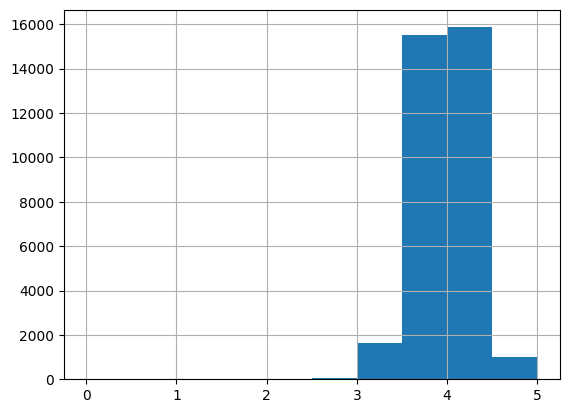

In [111]:
#check distribution of target
y.hist()
plt.show()

In [112]:
#Target distribution is punctuation from 0 to 5

In [113]:
X.drop(['4_star','3_star','2_star','1_star'], axis=1, inplace=True)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
#encode categorical features and standardize numerical features
categorical_features = ['genre']

numerical_features = [col for col in X.columns if col not in categorical_features]

In [116]:
#define pipeline again 
#One potential issue could be StandardScaler(with_mean=False). 
#Typically, StandardScaler is used with centering (with_mean=True), so let's try that.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(with_mean=True), numerical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [117]:
#Fit and transform the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [118]:
#models
models = LinearRegression(), DecisionTreeRegressor(), KNeighborsRegressor()

#cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#evaluate models
for model in models:
    scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='r2')
    print(f'{type(model).__name__}: R2 = {scores.mean():.2f}')

LinearRegression: R2 = -130902784664974336.00
DecisionTreeRegressor: R2 = 0.80
KNeighborsRegressor: R2 = 0.62


In [119]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34136 entries, 0 to 52477
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   series        34136 non-null  int64  
 1   pages         34136 non-null  int64  
 2   awards        34136 non-null  int64  
 3   numratings    34136 non-null  float64
 4   likedpercent  34136 non-null  float64
 5   bbescore      34136 non-null  int64  
 6   bbevotes      34136 non-null  int64  
 7   price         34136 non-null  float64
 8   5_star        34136 non-null  int64  
 9   genre         34136 non-null  object 
 10  price_sqrt    34136 non-null  float64
 11  pages_log     34136 non-null  float64
dtypes: float64(5), int64(6), object(1)
memory usage: 4.4+ MB


In [120]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode categorical features and standardize numerical features
categorical_features = ['genre']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Define pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)  # StandardScaler with centering
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Define models
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    KNeighborsRegressor()
]

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models
for model in models:
    scores = cross_val_score(model, X_train_processed, y_train, cv=cv, scoring='r2')
    print(f'{type(model).__name__}: R2 = {scores.mean():.2f}')

# Train and evaluate models on the test set
for model in models:
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    r2 = r2_score(y_test, y_pred)
    print(f'{type(model).__name__}: Test R2 = {r2:.2f}')

LinearRegression: R2 = -130902784664974336.00
DecisionTreeRegressor: R2 = 0.80
KNeighborsRegressor: R2 = 0.62
LinearRegression: Test R2 = 0.71
DecisionTreeRegressor: Test R2 = 0.82
KNeighborsRegressor: Test R2 = 0.69


 the LinearRegression model shows a reasonable R-squared score on the test set but an extremely large negative R-squared score during cross-validation, it suggests there might be an issue with the cross-validation procedure or the data splitting

In [121]:
# Check target distribution in each fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_num = 1
for train_index, val_index in kf.split(X_train_processed):
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    print(f'Fold {fold_num}')
    print(f'Training set target distribution: mean = {y_train_fold.mean()}, std = {y_train_fold.std()}')
    print(f'Validation set target distribution: mean = {y_val_fold.mean()}, std = {y_val_fold.std()}')
    fold_num += 1

Fold 1
Training set target distribution: mean = 3.9791737617870546, std = 0.30190764401741826
Validation set target distribution: mean = 3.979765653606737, std = 0.31726666944636467
Fold 2
Training set target distribution: mean = 3.979030486130184, std = 0.3057334528373556
Validation set target distribution: mean = 3.9803387037715123, std = 0.30225444598659545
Fold 3
Training set target distribution: mean = 3.9790616131099514, std = 0.3063913488393047
Validation set target distribution: mean = 3.9802142072500915, std = 0.29957824512918463
Fold 4
Training set target distribution: mean = 3.979616881036298, std = 0.306575269286497
Validation set target distribution: mean = 3.9779930415674785, std = 0.29882143458664606
Fold 5
Training set target distribution: mean = 3.9795779740925528, std = 0.304553145996988
Validation set target distribution: mean = 3.9781486907159858, std = 0.3069840241345385


In [122]:
# Check for consistency in processed data
print(f'Processed X_train shape: {X_train_processed.shape}')
print(f'Processed X_test shape: {X_test_processed.shape}')


Processed X_train shape: (27308, 36)
Processed X_test shape: (6828, 36)


Trying to use RobustScaling

In [123]:
# Define a pipeline that uses RobustScaler
from sklearn.preprocessing import RobustScaler

# Define a pipeline that uses RobustScaler
# Encode categorical features and standardize numerical features
categorical_features = ['genre']
numerical_features = [col for col in X.columns if col not in categorical_features]


# Create a column transformer with RobustScaler for numerical features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define a pipeline that uses the preprocessor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the data using the updated pipeline
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [124]:
# Define the models
models = [LinearRegression(), DecisionTreeRegressor(), KNeighborsRegressor()]

# Perform cross-validation and print R2 scores
for model in models:
    print(f'\nEvaluating {type(model).__name__}')
    scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='r2')
    print(f'R2 scores: {scores}')
    print(f'Mean R2: {scores.mean():.2f}')


Evaluating LinearRegression
R2 scores: [0.67401985 0.70679786 0.67773751 0.6433081  0.63261524]
Mean R2: 0.67

Evaluating DecisionTreeRegressor
R2 scores: [0.80532817 0.78180026 0.7965713  0.81428872 0.84339166]
Mean R2: 0.81

Evaluating KNeighborsRegressor
R2 scores: [0.63143984 0.67950945 0.62755497 0.60396408 0.59152535]
Mean R2: 0.63


In this case, given that the Decision Tree Regressor has shown the best performance, lets keep exploring further improvement and validation

In [125]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Decision Tree Regressor
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the Grid Search with cross-validation
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')

# Fit the Grid Search to the data
grid_search.fit(X_train_processed, y_train)

# Print the best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation R2 score: {grid_search.best_score_:.2f}')

# Evaluate the best estimator on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test_processed, y_test)
print(f'Test set R2 score: {test_score:.2f}')


Best parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation R2 score: 0.84
Test set R2 score: 0.86


In [126]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_processed, y_train, test_size=0.2, random_state=42)

# Define the parameter grid for Decision Tree Regressor
param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Initialize the Grid Search with cross-validation
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation R2 score: {grid_search.best_score_:.2f}')

# Evaluate the best estimator on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_score = r2_score(y_test, y_pred)
print(f'Test set R2 score: {test_score:.2f}')

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20}
Best cross-validation R2 score: 0.81
Test set R2 score: 0.86


In [127]:
y_pred = best_model.predict(X_test)

In [128]:
y_pred

array([4.294     , 4.20692308, 4.16555556, ..., 4.11333333, 4.090625  ,
       3.89636364])

Feature Importance Analysis:

In [129]:

# evaluate feature importance
feature_importances = best_model.feature_importances_

#cross-validation with the best model
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
print(f'Cross-validation R2 scores: {cv_scores}')
print(f'Mean Cross-validation R2: {cv_scores.mean():.2f}')



Cross-validation R2 scores: [0.79011957 0.8114214  0.79978763 0.81361506 0.82952235]
Mean Cross-validation R2: 0.81


#### Given that the X DataFrame has 12 columns with mixed data types, and will be processed it using ColumnTransformer while retaining column names. This will be needed for plotting feature importance which is a valuable step in understanding which features are most influential in the model's predictions.

In [130]:
to_drop = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate',
                'language','bookformat','publisher','characters', 'setting','author',
                'edition','numratings_log','4_star','3_star','2_star','1_star']

In [131]:
X_features = best.drop(columns=['rating'] + to_drop, axis=1)  
y_target = best['rating']

In [132]:

categorical_features = ['genre']  
numerical_features = X_features.columns.drop(categorical_features)

# Define the preprocessor with RobustScaler for numerical features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())  
])


pipeline.fit(X_features, y_target)

# Get feature names after transformation

encoded_categorical_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=categorical_features)

processed_feature_names = list(numerical_features) + list(encoded_categorical_columns)

X_processed = pipeline.named_steps['preprocessor'].transform(X_features)

#convert X_processed back to a DataFrame with column names
X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)


In [133]:

X_processed_df.head()

,series,pages,awards,numratings,likedpercent,bbescore,bbevotes,price,5_star,price_sqrt,pages_log,genre_Arts and Creativity,genre_Classics,genre_Comic and Manga,genre_Computer Science,genre_Crime,genre_Culture and Society,genre_Economy,genre_Erotica,genre_Fantasy,genre_Fiction,genre_Health,genre_History,genre_Horror,genre_Languages,genre_Literature by Region,genre_Mystery,genre_Nature and Animals,genre_Non-Fiction and Others,genre_Psychology,genre_Religion and Spirituality,genre_Romance,genre_Science,genre_Science Fiction,genre_Sports,genre_World
0,1.0,0.385542,1.0,532.310315,0.500000,25807.913793,15257.5,0.118598,807.939230,0.117847,0.343260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,3.373494,1.0,209.139967,0.833333,22690.818966,13461.0,0.735849,373.623651,0.662086,1.889064,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.150602,1.0,414.351577,-2.500000,12580.603448,7436.5,-1.196765,410.652745,-2.006867,0.878281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.457831,1.0,152.898831,0.500000,11833.715517,7083.5,-1.150943,245.652745,-1.819924,1.055765,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-1.018072,1.0,228.608749,-0.333333,11004.318966,6631.5,-0.061995,231.230878,-0.063825,-1.438037,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
# Get feature names from the original dataset or feature columns
feature_names = X_processed_df.columns  

In [135]:
# Sort feature importances in descending order
sorted_idx = np.argsort(feature_importances)[::-1]

In [136]:
# Rearrange feature names so they match the sorted feature importances
sorted_feature_names = feature_names[sorted_idx]

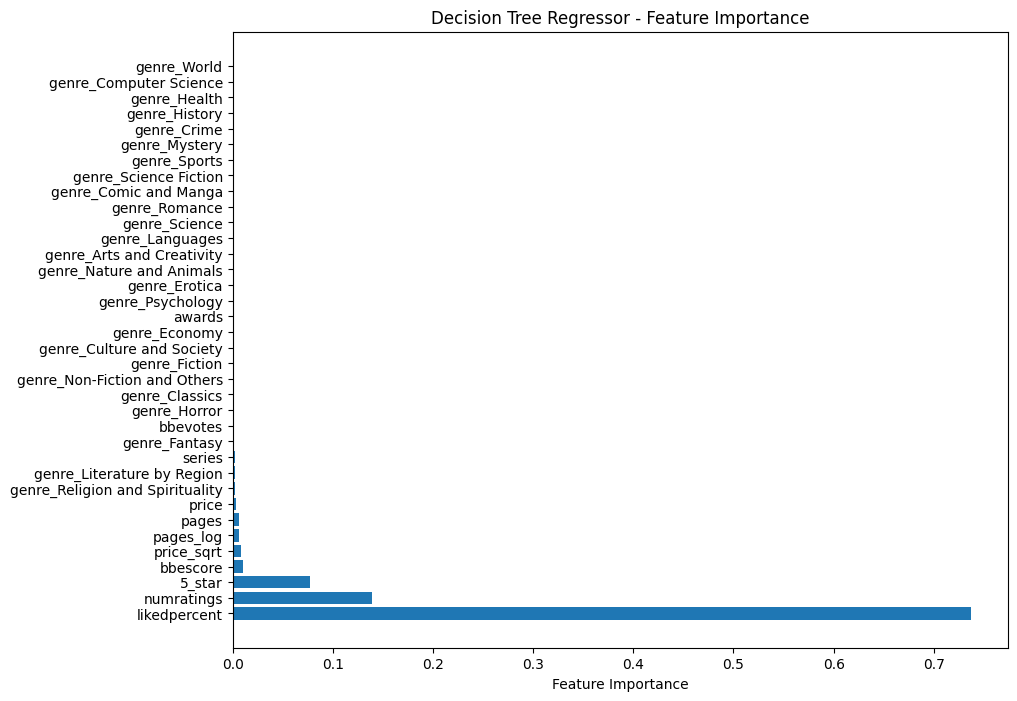

In [137]:
# Plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, feature_importances[sorted_idx], align='center')
plt.xlabel('Feature Importance')
plt.title('Decision Tree Regressor - Feature Importance')
plt.show()

In [ ]:
X_processed_df.info()

In [ ]:
vif_data = pd.DataFrame()
prueba=X_processed_df.copy()
prueba.drop(['bbescore'], axis=1, inplace=True)
vif_data["Variable"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] #shape 1 se refiere a columnas
print(vif_data)

In [ ]:
vif_data = pd.DataFrame()
prueba=X_processed_df.copy()
prueba.drop(['bbescore','price_sqrt'], axis=1, inplace=True)
vif_data["Variable"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] #shape 1 se refiere a columnas
print(vif_data)

In [150]:
vif_data = pd.DataFrame()
prueba=X_processed_df.copy()
prueba.drop(['bbescore','price_sqrt','5_star'], axis=1, inplace=True)
vif_data["Variable"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] #shape 1 se refiere a columnas
print(vif_data)

                           Variable       VIF
0                            series  1.196325
1                             pages  3.619389
2                            awards  1.061620
3                        numratings  2.301244
4                      likedpercent  1.068135
5                          bbevotes  2.235306
6                             price  1.039399
7                         pages_log  3.645284
8         genre_Arts and Creativity  1.010868
9                    genre_Classics  1.375730
10            genre_Comic and Manga  1.028024
11           genre_Computer Science  1.000430
12                      genre_Crime  1.000441
13        genre_Culture and Society  1.000651
14                    genre_Economy  1.014863
15                    genre_Erotica  1.111119
16                    genre_Fantasy  1.235762
17                    genre_Fiction  1.044343
18                     genre_Health  1.000481
19                    genre_History  1.001324
20                     genre_Horro

In [176]:
to_drop = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate',
                'language','bookformat','publisher','characters', 'setting','author',
                'edition','numratings_log','4_star','3_star','2_star','1_star','bbescore','price_sqrt','5_star']

In [177]:
X = best.drop(columns=['rating'] + to_drop, axis=1)  
y = best['rating']

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [179]:
categorical_features = ['genre']  
numerical_features = X.columns.drop(categorical_features)

# Define the preprocessor with RobustScaler for numerical features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())  
])

#fit the pipeline
pipeline.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['series', 'pages', 'awards', 'numratings', 'likedpercent', 'bbevotes',
       'price', 'pages_log'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['genre'])])),
                ('model', DecisionTreeRegressor())])

In [180]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.6075314969328357


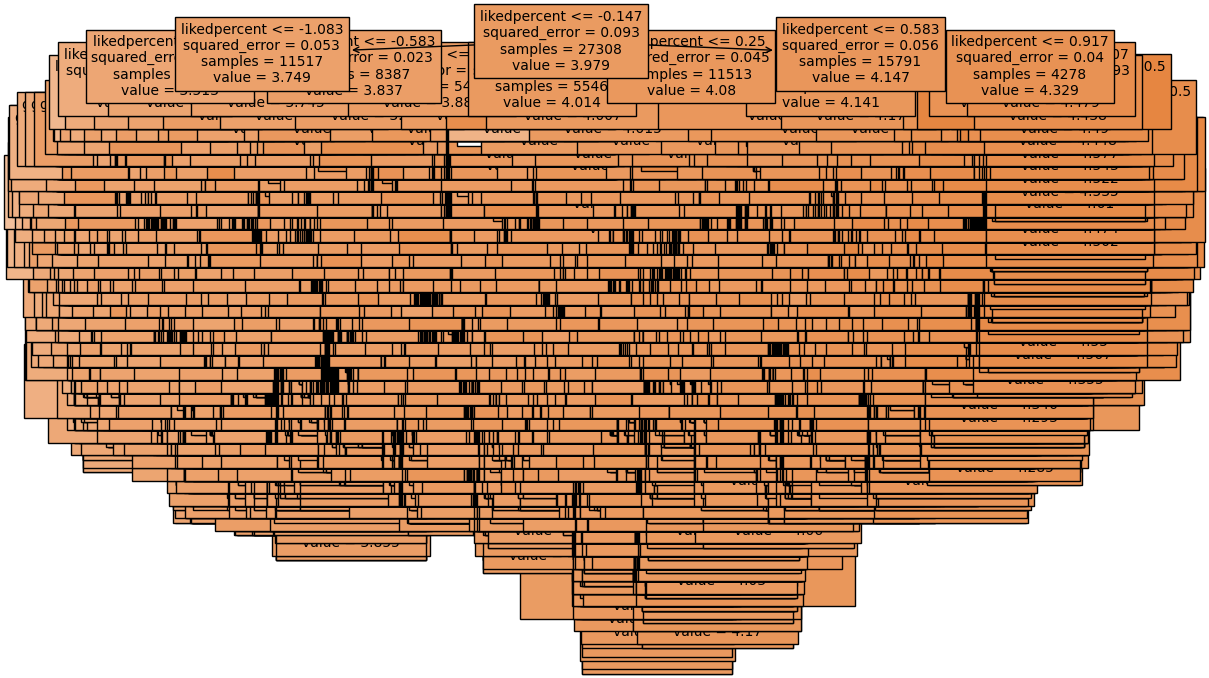

In [197]:

# Define the columns to drop
to_drop = ['bookid', 'title', 'description', 'isbn', 'coverimg', 'publishdate',
           'language', 'bookformat', 'publisher', 'characters', 'setting', 'author',
           'edition', 'numratings_log', '4_star', '3_star', '2_star', '1_star', 'bbescore', 'price_sqrt', '5_star']

# Prepare the feature matrix X and the target vector y
X = best.drop(columns=['rating'] + to_drop, axis=1)
y = best['rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical_features = ['genre']
numerical_features = X.columns.drop(categorical_features)

# Define the preprocessor with RobustScaler for numerical features and OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())  
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Extract the feature names after preprocessing
preprocessed_feature_names = numerical_features.tolist() + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(pipeline.named_steps['model'], feature_names=preprocessed_feature_names, filled=True, fontsize=10)
plt.show()


In [198]:
# Evaluate the model
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.6096481387764439


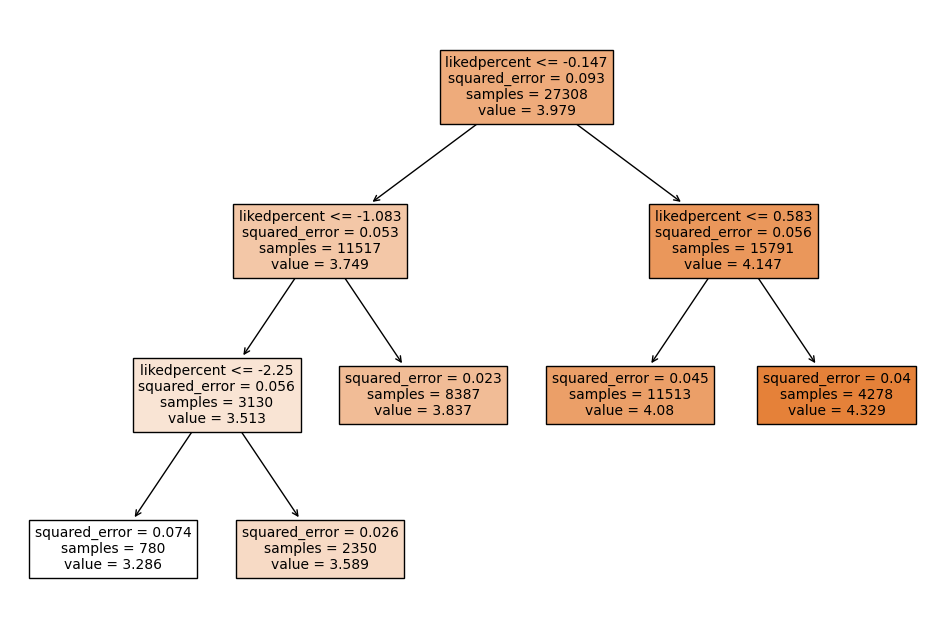

In [206]:
#fitting separate decision tree with max_leaf_nodes for visualization
simple_tree = DecisionTreeRegressor(max_leaf_nodes=5, random_state=42)  
simple_tree.fit(pipeline.named_steps['preprocessor'].transform(X_train), y_train)

#feature names after preprocessing
preprocessed_feature_names = numerical_features.tolist() + list(pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features))

#Plot
plt.figure(figsize=(12, 8))
plot_tree(simple_tree, feature_names=preprocessed_feature_names, filled=True, fontsize=10)
plt.show()

Doing this to get a VIF of the X with all the encoded categorical and scaled numerical

- By transforming the features using the preprocessor, I ensure that the VIF calculation takes into account the exact data format that the model will use. This is important because VIF should be calculated on the actual features used in the model, which include the scaled numerical features and the one-hot encoded categorical features.

In [304]:
to_drop = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate',
                'language','bookformat','publisher','characters', 'setting','author',
                'edition','numratings_log','4_star','3_star','2_star','1_star']


In [305]:
# Prepare the feature matrix X and the target vector y
X = best.drop(columns=['rating'] + to_drop, axis=1)
y = best['rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [306]:
# Define categorical and numerical features
categorical_features = ['genre']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [307]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['series', 'pages', 'awards',
                                                   'numratings', 'likedpercent',
                                                   'bbescore', 'bbevotes',
                                                   'price', '5_star',
                                                   'price_sqrt', 'pages_log']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['genre'])])),
                ('model', DecisionTreeRegressor())])

Keeping processed-encoded X in a df

In [308]:
# Transform the training and test data using the fitted pipeline (excluding the model step)
preprocessor_fit = pipeline.named_steps['preprocessor']
X_train_processed = preprocessor_fit.transform(X_train)
X_test_processed = preprocessor_fit.transform(X_test)

# Get feature names after transformation
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
num_features = numerical_features
all_features = list(num_features) + list(cat_features)

# Convert to DataFrame
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_features)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_features)

In [309]:
model = DecisionTreeRegressor()
model.fit(X_train_processed_df, y_train)
predictions = model.predict(X_test_processed_df)

In [310]:
# Evaluate the model
r2 = r2_score(y_test, predictions)
print("R-squared:", r2)

R-squared: 0.8187281348465142


In [311]:
X_train_processed_df

,series,pages,awards,numratings,likedpercent,bbescore,bbevotes,price,5_star,price_sqrt,pages_log,genre_Arts and Creativity,genre_Classics,genre_Comic and Manga,genre_Computer Science,genre_Crime,genre_Culture and Society,genre_Economy,genre_Erotica,genre_Fantasy,genre_Fiction,genre_Health,genre_History,genre_Horror,genre_Languages,genre_Literature by Region,genre_Mystery,genre_Nature and Animals,genre_Non-Fiction and Others,genre_Psychology,genre_Religion and Spirituality,genre_Romance,genre_Science,genre_Science Fiction,genre_Sports,genre_World
0,1.0,0.342857,0.0,-0.153830,0.333333,-0.068966,0.0,2.180593,-0.004434,1.670900,0.307169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.427068,0.0,-0.245185,-0.333333,0.017241,0.0,1.212938,-0.243860,1.027204,-0.472682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,-0.024060,0.0,1.764703,-0.666667,1.439655,1.0,-0.857143,1.795228,-1.117711,-0.023621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.497744,0.0,-0.176917,0.166667,-0.224138,0.0,0.237197,-0.204889,0.230928,1.074067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.637594,0.0,-0.300875,-0.500000,-0.077586,0.0,3.070081,-0.285864,2.185975,0.535422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27303,0.0,0.240602,0.0,-0.302365,-0.500000,0.000000,0.0,0.671159,-0.286564,0.609980,0.220826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27304,0.0,-0.499248,1.0,7.113428,0.166667,1.775862,1.5,-0.258760,7.063999,-0.278592,-0.566182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27305,0.0,-0.264662,0.0,0.087135,0.000000,0.560345,0.5,0.156334,0.212123,0.154423,-0.278287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27306,1.0,1.046617,0.0,5.024349,-1.833333,45.189655,37.0,-0.649596,4.740914,-0.780879,0.811348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Checking VIF again, removing one feature at a time

In [312]:
# Calculate VIF for each feature in the processed DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_processed_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_processed_df.values, i) for i in range(X_train_processed_df.shape[1])]

In [ ]:
print(vif_data)

In [ ]:
#I will be dropping features one by one based on the highest VIF

In [314]:
vif_data = pd.DataFrame()
prueba=X_train_processed_df.copy()
prueba.drop(['bbescore'], axis=1, inplace=True)
vif_data["feature"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] 
print(vif_data)

                            feature        VIF
0                            series   1.197712
1                             pages   3.587377
2                            awards   1.061274
3                        numratings  14.190521
4                      likedpercent   1.078844
5                          bbevotes   1.967531
6                             price  29.750332
7                            5_star  14.126669
8                        price_sqrt  29.779633
9                         pages_log   3.611109
10        genre_Arts and Creativity   1.012200
11                   genre_Classics   1.446684
12            genre_Comic and Manga   1.029941
13           genre_Computer Science   1.000456
14                      genre_Crime   1.000831
15        genre_Culture and Society   1.001313
16                    genre_Economy   1.022720
17                    genre_Erotica   1.127298
18                    genre_Fantasy   1.257330
19                    genre_Fiction   1.056736
20           

In [ ]:
#Dropping the feature 'bbescore' from the actual dataframe

In [ ]:
X_train_processed_df

In [318]:
to_drop = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate',
                'language','bookformat','publisher','characters', 'setting','author',
                'edition','numratings_log','4_star','3_star','2_star','1_star','bbescore']

In [319]:
# Prepare the feature matrix X and the target vector y
X = best.drop(columns=['rating'] + to_drop, axis=1)
y = best['rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [320]:
# Define categorical and numerical features
categorical_features = ['genre']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [321]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['series', 'pages', 'awards',
                                                   'numratings', 'likedpercent',
                                                   'bbevotes', 'price',
                                                   '5_star', 'price_sqrt',
                                                   'pages_log']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['genre'])])),
                ('model', DecisionTreeRegressor())])

In [322]:
#evaluate the model 

predictions = pipeline.predict(X_test)
r2 = r2_score(y_test, predictions)
print("R-squared:", r2)

R-squared: 0.8413867088671025


In [ ]:
#Checking VIF again

In [325]:
vif_data = pd.DataFrame()
prueba=X_train_processed_df.copy()
prueba.drop(['price','bbescore'], axis=1, inplace=True)
vif_data["feature"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] 
print(vif_data)

                            feature        VIF
0                            series   1.197656
1                             pages   3.587300
2                            awards   1.060891
3                        numratings  14.172651
4                      likedpercent   1.078650
5                          bbevotes   1.967522
6                            5_star  14.121345
7                        price_sqrt   1.041905
8                         pages_log   3.609321
9         genre_Arts and Creativity   1.011665
10                   genre_Classics   1.366647
11            genre_Comic and Manga   1.026822
12           genre_Computer Science   1.000249
13                      genre_Crime   1.000418
14        genre_Culture and Society   1.001032
15                    genre_Economy   1.012342
16                    genre_Erotica   1.106962
17                    genre_Fantasy   1.231925
18                    genre_Fiction   1.042333
19                     genre_Health   1.000514
20           

In [ ]:
#Checking by removing '5_star'

In [358]:
to_drop = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate',
                'language','bookformat','publisher','characters', 'setting','author',
                'edition','numratings_log','4_star','3_star','2_star','1_star','bbescore','5_star']

In [359]:
# Prepare the feature matrix X and the target vector y
X = best.drop(columns=['rating'] + to_drop, axis=1)
y = best['rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [360]:
# Define categorical and numerical features
categorical_features = ['genre']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [361]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['series', 'pages', 'awards',
                                                   'numratings', 'likedpercent',
                                                   'bbevotes', 'price',
                                                   'price_sqrt', 'pages_log']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['genre'])])),
                ('model', DecisionTreeRegressor())])

In [362]:
#evaluate the model 

predictions = pipeline.predict(X_test)
r2 = r2_score(y_test, predictions)
print("R-squared:", r2)

R-squared: 0.6069768889841742


In [374]:
vif_data = pd.DataFrame()
prueba=X_train_processed_df.copy()
prueba.drop(['price'], axis=1, inplace=True)
vif_data["feature"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] 
print(vif_data)

                            feature        VIF
0                            series   1.197656
1                             pages   3.587300
2                            awards   1.060891
3                        numratings  14.172651
4                      likedpercent   1.078650
5                          bbevotes   1.967522
6                            5_star  14.121345
7                        price_sqrt   1.041905
8                         pages_log   3.609321
9         genre_Arts and Creativity   1.011665
10                   genre_Classics   1.366647
11            genre_Comic and Manga   1.026822
12           genre_Computer Science   1.000249
13                      genre_Crime   1.000418
14        genre_Culture and Society   1.001032
15                    genre_Economy   1.012342
16                    genre_Erotica   1.106962
17                    genre_Fantasy   1.231925
18                    genre_Fiction   1.042333
19                     genre_Health   1.000514
20           

In [365]:
to_drop1 = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate',
                'language','bookformat','publisher','characters', 'setting','author',
                'edition','numratings_log','4_star','3_star','2_star','1_star','bbescore','price']

In [366]:
# Prepare the feature matrix X and the target vector y
X = best.drop(columns=['rating'] + to_drop1, axis=1)
y = best['rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [367]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34136 entries, 0 to 52477
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   series        34136 non-null  int64  
 1   pages         34136 non-null  int64  
 2   awards        34136 non-null  int64  
 3   numratings    34136 non-null  float64
 4   likedpercent  34136 non-null  float64
 5   bbevotes      34136 non-null  int64  
 6   5_star        34136 non-null  int64  
 7   genre         34136 non-null  object 
 8   price_sqrt    34136 non-null  float64
 9   pages_log     34136 non-null  float64
dtypes: float64(4), int64(5), object(1)
memory usage: 3.9+ MB


In [368]:
# Define categorical and numerical features
categorical_features = ['genre']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [369]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['series', 'pages', 'awards',
                                                   'numratings', 'likedpercent',
                                                   'bbevotes', '5_star',
                                                   'price_sqrt', 'pages_log']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['genre'])])),
                ('model', DecisionTreeRegressor())])

In [370]:
#evaluate the model 

predictions = pipeline.predict(X_test)  
r2 = r2_score(y_test, predictions)
print("R-squared:", r2)

R-squared: 0.8395592355821503


In [ ]:
#Removing price and 5_star

In [375]:
vif_data = pd.DataFrame()
prueba=X_train_processed_df.copy()
prueba.drop(['price','5_star'], axis=1, inplace=True)
vif_data["feature"] = prueba.columns
vif_data["VIF"] = [variance_inflation_factor(prueba.values, i) for i in range(prueba.shape[1])] 
print(vif_data)

                            feature       VIF
0                            series  1.196928
1                             pages  3.580662
2                            awards  1.060418
3                        numratings  1.994343
4                      likedpercent  1.070577
5                          bbevotes  1.931551
6                        price_sqrt  1.040998
7                         pages_log  3.604558
8         genre_Arts and Creativity  1.011664
9                    genre_Classics  1.366253
10            genre_Comic and Manga  1.026820
11           genre_Computer Science  1.000248
12                      genre_Crime  1.000417
13        genre_Culture and Society  1.001032
14                    genre_Economy  1.012316
15                    genre_Erotica  1.106954
16                    genre_Fantasy  1.231914
17                    genre_Fiction  1.042299
18                     genre_Health  1.000511
19                    genre_History  1.000946
20                     genre_Horro

In [376]:
to_drop1 = ['bookid', 'title', 'description', 'isbn', 'coverimg','publishdate',
                'language','bookformat','publisher','characters', 'setting','author',
                'edition','numratings_log','4_star','3_star','2_star','1_star','bbescore','price','5_star']

In [377]:
# Prepare the feature matrix X and the target vector y
X = best.drop(columns=['rating'] + to_drop1, axis=1)
y = best['rating']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [378]:
# Define categorical and numerical features
categorical_features = ['genre']
numerical_features = [col for col in X.columns if col not in categorical_features]

In [379]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Define the pipeline with the preprocessor and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['series', 'pages', 'awards',
                                                   'numratings', 'likedpercent',
                                                   'bbevotes', 'price_sqrt',
                                                   'pages_log']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['genre'])])),
                ('model', DecisionTreeRegressor())])

In [380]:
#evaluate the model 

predictions = pipeline.predict(X_test)  
r2 = r2_score(y_test, predictions)
print("R-squared:", r2)

R-squared: 0.6112126274129748
